In [4]:
# ===============================
# 1. GEREKLİ KÜTÜPHANELER
# ===============================
import os
import shutil
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [5]:
# ===============================
# 2. VERİ SETİNİ TRAIN / VAL / TEST AYIRMA
# ===============================
base_dir = "realwaste-main/RealWaste"
output_dir = "realwaste_split"

os.makedirs(output_dir, exist_ok=True)

for cls in os.listdir(base_dir):
    cls_path = os.path.join(base_dir, cls)
    if not os.path.isdir(cls_path):
        continue

    images = os.listdir(cls_path)
    train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    for split, img_list in [("train", train_imgs), ("val", val_imgs), ("test", test_imgs)]:
        split_dir = os.path.join(output_dir, split, cls)
        os.makedirs(split_dir, exist_ok=True)
        for img in img_list:
            shutil.copy(os.path.join(cls_path, img), os.path.join(split_dir, img))

print("Veri seti hazır")


Veri seti hazır


In [6]:
# ===============================
# 3. DATA AUGMENTATION (DERS DÜZEYİ)
# ===============================
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder("realwaste_split/train", transform=transform_train)
val_dataset   = datasets.ImageFolder("realwaste_split/val", transform=transform_test)
test_dataset  = datasets.ImageFolder("realwaste_split/test", transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
num_classes = len(class_names)


In [7]:
# ===============================
# 4. MODEL (RESNET18 - TRANSFER LEARNING)
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights="IMAGENET1K_V1")

# Önceki katmanları dondur
for param in model.parameters():
    param.requires_grad = False

# Son katmanı değiştir
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


0.8%

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Lenovo/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100.0%


In [8]:
# ===============================
# 5. MODEL EĞİTİMİ
# ===============================
epochs = 10

for epoch in range(epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss:.4f} - Accuracy: {train_acc:.2f}%")


Epoch [1/10] - Loss: 157.9024 - Accuracy: 48.90%
Epoch [2/10] - Loss: 104.1031 - Accuracy: 68.52%
Epoch [3/10] - Loss: 91.4180 - Accuracy: 71.26%
Epoch [4/10] - Loss: 82.6428 - Accuracy: 73.10%
Epoch [5/10] - Loss: 77.6891 - Accuracy: 75.29%
Epoch [6/10] - Loss: 75.9647 - Accuracy: 75.35%
Epoch [7/10] - Loss: 72.6390 - Accuracy: 76.17%
Epoch [8/10] - Loss: 70.5443 - Accuracy: 77.07%
Epoch [9/10] - Loss: 65.6854 - Accuracy: 78.54%
Epoch [10/10] - Loss: 65.9086 - Accuracy: 78.51%


In [9]:
# ===============================
# 6. TEST + METRİKLER
# ===============================
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))



Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.80      0.61      0.69        70
      Food Organics       0.63      0.95      0.76        62
              Glass       0.92      0.70      0.79        63
              Metal       0.63      0.81      0.71       119
Miscellaneous Trash       0.53      0.31      0.39        75
              Paper       0.82      0.67      0.74        75
            Plastic       0.69      0.76      0.72       139
      Textile Trash       0.67      0.67      0.67        48
         Vegetation       0.95      0.94      0.95        66

           accuracy                           0.72       717
          macro avg       0.74      0.71      0.71       717
       weighted avg       0.73      0.72      0.71       717



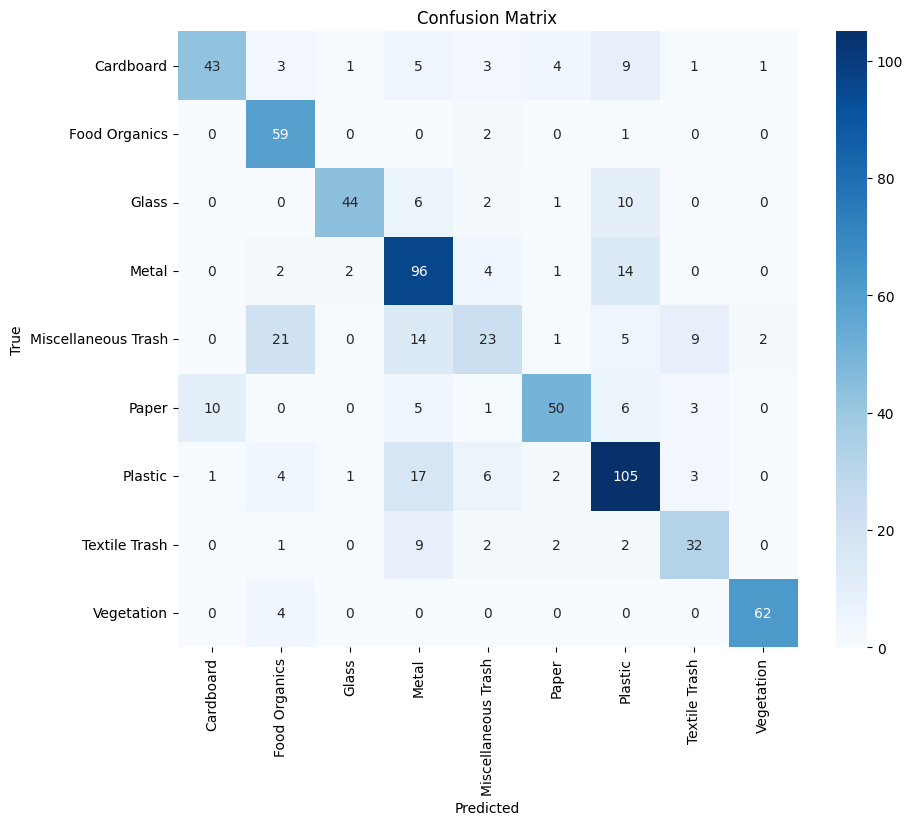

In [10]:
# ===============================
# 7. CONFUSION MATRIX
# ===============================
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [11]:
torch.save(model.state_dict(), "realwaste_resnet18.pth")
print("Model başarıyla kaydedildi")


Model başarıyla kaydedildi


In [12]:
!pip install gradio


  Using cached anyio-4.12.0-py3-none-any.whl.metadata (4.3 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached pyyaml-6.0.3-cp313-cp313-win_amd64.whl.metadata (2.4 kB)
  Using cached idna-3.11-py3-none-any.whl.metadata (8.4 kB)
  Using cached certifi-2025.11.12-py3-none-any.whl.metadata (2.5 kB)
  Using cached httpcore-1.0.9-py3-none-any.whl.metadata (21 kB)
  Using cached h11-0.16.0-py3-none-any.whl.metadata (8.3 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 0.0/23.0 MB ? eta -:--:--
   ---- ----------------------------------- 2.6/23.0 MB 14.2 MB/s eta 0:00:02
   --------- ------------------------------ 5.2/23.0 MB 13.7 MB/s eta 0:00:02
   -------------- ------------------------- 8.1/23.0 MB 13.8 MB/s eta 0:00:02
   ------------------- -------------------- 11.0/23.0 MB 13.8 MB/s eta 0:00:01
   ----------------------- ---------------- 13.6/23.0 MB 13.8 MB/s eta 0:00:01
   ----------------------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
import gradio as gr
import torch
import torchvision.transforms as transforms
from torchvision import models
from torch import nn
from PIL import Image

# ===============================
# SINIF İSİMLERİ
# ===============================
class_names = [
    'Cardboard',
    'Food Organics',
    'Glass',
    'Metal',
    'Miscellaneous Trash',
    'Paper',
    'Plastic',
    'Textile Trash',
    'Vegetation'
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===============================
# MODEL YÜKLE
# ===============================
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model.load_state_dict(torch.load("realwaste_resnet18.pth", map_location=device))
model.to(device)
model.eval()

# ===============================
# TRANSFORM
# ===============================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# ===============================
# TAHMİN FONKSİYONU
# ===============================
def predict(image):
    image = Image.fromarray(image)
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        probs = torch.softmax(output, dim=1)[0]
        conf, pred = torch.max(probs, 0)

    predicted_class = class_names[pred.item()]
    confidence = conf.item() * 100

    return predicted_class, f"{confidence:.2f}%"

# ===============================
# GRADIO ARAYÜZ
# ===============================
with gr.Blocks() as demo:

    gr.Markdown(
        """
        # Atik Siniflandirma Sistemi
        Derin ogrenme tabanli goruntu analizi ile atik turu tahmini.
        """
    )

    with gr.Row():
        with gr.Column():
            image_input = gr.Image(
                type="numpy",
                label="Atik Goruntusu Yukle"
            )
            analyze_btn = gr.Button("Analiz Et")

        with gr.Column():
            class_output = gr.Textbox(
                label="Tahmin Edilen Sinif",
                interactive=False
            )
            conf_output = gr.Textbox(
                label="Guven Orani",
                interactive=False
            )

    analyze_btn.click(
        fn=predict,
        inputs=image_input,
        outputs=[class_output, conf_output]
    )

    gr.Markdown(
        """
        ---
        Model: ResNet18 (Transfer Learning)  
        Veri Seti: RealWaste  
        Sinif Sayisi: 9
        """
    )

demo.launch(share=True)
   

* Running on local URL:  http://127.0.0.1:7861

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.
